<a href="https://colab.research.google.com/github/ivynky/Bank-Marketing/blob/main/Spaceship_Titanic_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: The Cosmic Mystery of Spaceship Titanic: A Data Science Investigation
###### (https://www.kaggle.com/competitions/spaceship-titanic)

**Introduction:**

Welcome to the year 2912, where the enigmatic Spaceship Titanic's collision with a spacetime anomaly has led to a cosmic mystery. Our task is to predict whether passengers were transported to an alternate dimension during this cataclysmic event. In this summary, we'll explore the dataset provided, consisting of personal records recovered from the ship's damaged computer system.

**Dataset Description:**

train.csv: Personal records for about two-thirds (~8700) of the
passengers, used as training data.

*   PassengerId: Unique ID for each passenger.gggg indicates a group the passenger is travelling with and pp is their number within the group.
* HomePlanet: The planet the passenger departed from.
*   CryoSleep: Indicates if the passenger elected to be in suspended animation.
*  Cabin: The cabin number where the passenger stayed.Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
*   Destination: The planet the passenger was headed to.
*   Age: Age of the passenger.
*  VIP: Indicates if the passenger paid for VIP service.
*  RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Amount billed at luxury amenities.
*   Name: First and last names of the passenger.
*   Transported: Whether the passenger was transported to another dimension (Target).

**test.csv:** Personal records for the remaining one-third (~4300) of the passengers, used for prediction.


**Objective:**

Our goal is to predict whether each passenger in the test set was transported to another dimension during the collision. We'll utilize machine learning techniques to analyze the provided data and make predictions.

**Approach:**


Data Exploration: We'll explore the dataset to understand its structure, distribution, and deal with missing values.

Feature Engineering: We'll engineer new features if needed and preprocess the data for modeling.

Model Selection: We'll select appropriate machine learning models and train them using the training data.

Model Evaluation: We'll evaluate the performance of the trained models using appropriate evaluation metrics.

Prediction: Finally, we'll make predictions for the passengers in the test set and submit our results.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Cleaning



In [ ]:
#Importing Necessary Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#Mounting google drive to avoid data uploads
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading both Train and Test Files
#NOTE: ONLY THE TRAIN FILE WILL BE USED TO TRAIN AND TEST THE ACCURACY.
#NOTE: THE TEST FILE IS AN UNSEEN DATASET WITH NO OUTCOME VARIABLE. THE OUTCOME WILL BE PREDICTED AFTER MODEL SELECTION

df_train = pd.read_csv("/content/drive/MyDrive/train.csv")
df_predict = pd.read_csv("/content/drive/MyDrive/predict.csv")

## Training Data

In [ ]:
#preview of the train & predict data
df_train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [ ]:
# Display unique values for each categorical variable
print("Unique values for categorical variables:")
for column in df_train.select_dtypes(include=['object']).columns:
    print(f"{column}: {df_train[column].nunique()}")

# Print unique values and counts for specific columns
print("Unique values for specific columns:")
columns_to_print = ["HomePlanet", "Destination"]
for column in columns_to_print:
    unique_values = df_train[column].value_counts()
    print(f"{column}:")
    for value, count in unique_values.items():
        print(f"{value}: {count}")


Unique values for categorical variables:
PassengerId: 8693
HomePlanet: 3
CryoSleep: 2
Cabin: 6560
Destination: 3
VIP: 2
Name: 8473
Unique values for specific columns:
HomePlanet:
Earth: 4602
Europa: 2131
Mars: 1759
Destination:
TRAPPIST-1e: 5915
55 Cancri e: 1800
PSO J318.5-22: 796



There are 8473 unique names which is less than total passenger id.
It is worth to explore rows with repeated names.


In [ ]:
#Checking Null cells
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

###Dealing with Null Cells

**Dealing with Null Cells:**

- The first four digits of Passenger ID were used to identify groups to fill null cells of Cabin, Destination, Homeplanet.  
- CryoSleep, VIP and other null cells are filled with the mode of the same columns.
- The null cells of the continous variables are filed with the mean of the individual columns.

*This cleaning process will be replicated for the predict data set (df_predict).

In [ ]:
## Extract first four digits of PassengerId to create GroupId column
df_train['GroupId'] = df_train['PassengerId'].str[:4]

# Get unique GroupId values
unique_group_ids = df_train['GroupId'].unique()

# Iterate over unique GroupId values
for group_id in unique_group_ids:
    # Find rows with the same GroupId
    group_rows = df_train[df_train['GroupId'] == group_id]

    # Find non-null values of Cabin, HomePlanet, and Destination for this group
    cabin_not_null = group_rows['Cabin'].notnull()
    homeplanet_not_null = group_rows['HomePlanet'].notnull()
    destination_not_null = group_rows['Destination'].notnull()

    # Get non-null values
    cabin_value = group_rows.loc[cabin_not_null, 'Cabin'].iloc[0] if any(cabin_not_null) else None
    homeplanet_value = group_rows.loc[homeplanet_not_null, 'HomePlanet'].iloc[0] if any(homeplanet_not_null) else None
    destination_value = group_rows.loc[destination_not_null, 'Destination'].iloc[0] if any(destination_not_null) else None

    # Fill null cells of Cabin, HomePlanet, and Destination columns with corresponding values
    if cabin_value is not None:
        df_train.loc[df_train['GroupId'] == group_id, 'Cabin'] = df_train.loc[df_train['GroupId'] == group_id, 'Cabin'].fillna(cabin_value)
    if homeplanet_value is not None:
        df_train.loc[df_train['GroupId'] == group_id, 'HomePlanet'] = df_train.loc[df_train['GroupId'] == group_id, 'HomePlanet'].fillna(homeplanet_value)
    if destination_value is not None:
        df_train.loc[df_train['GroupId'] == group_id, 'Destination'] = df_train.loc[df_train['GroupId'] == group_id, 'Destination'].fillna(destination_value)


#Checking Null values after operation
df_train.isnull().sum()


PassengerId       0
HomePlanet      111
CryoSleep       217
Cabin            99
Destination     103
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
GroupId           0
dtype: int64

### Feature Engineering


- Extracted Deck values from Cabin Id to use it in further model fitting

In [ ]:
# Extracting deck and side from Cabin column
df_train['Cabin'] = df_train['Cabin'].astype(str)
df_train['Deck'] = df_train['Cabin'].str[0]


# Display the first few rows to verify the changes
print(df_train.head(3))

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck             Name  \
0          0.0        0.0           0.0     0.0     0.0  Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0     Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0    Altark Susent   

   Transported GroupId Deck  
0        False    0001    B  
1         True    0002    F  
2        False    0003    A  


In [ ]:
#CATEGORICAL VARIABLE

#Identifying Categorical Features
cat_columns = (['HomePlanet', 'CryoSleep', 'Destination','VIP','Deck'])
cat_df = df_train[cat_columns]

#Filling null cells with mode
df_train[cat_columns] = df_train[cat_columns].fillna(df_train.mode().iloc[0])
mode_value = df_train['Deck'].mode()[0]
df_train['Deck'] = df_train['Deck'].replace('n', mode_value) # the null values of Deck might not be identified

#CONTINUOUS VARIABLE

#Identifying Continuous Features
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).columns

#Filling null cells with mean
column_means = df_train[numerical_columns].mean()
df_train[numerical_columns] = df_train[numerical_columns].fillna(column_means)

#Checking Null values after operation
df_train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
GroupId           0
Deck              0
dtype: int64

##Prediction Dataset

In [ ]:
#preview of the prediction data
df_predict.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


In [ ]:
#Understanding the shape
df_predict.shape

(4277, 13)

In [ ]:
#Checking Null cells
df_predict.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

**Dealing with Null Cells:**

- The Categorical features with null cells to be ffilled with most frequent value
- The Continuos Featured with null cells to be filled with mean value

In [ ]:
## Extract first four digits of PassengerId to create GroupId column
df_predict['GroupId'] = df_predict['PassengerId'].str[:4]

# Get unique GroupId values
unique_group_ids_predict = df_predict['GroupId'].unique()

# Iterate over unique GroupId values
for group_id in unique_group_ids_predict:
    # Find rows with the same GroupId
    group_rows_predict = df_predict[df_predict['GroupId'] == group_id]

    # Find non-null values of Cabin, HomePlanet, and Destination for this group
    cabin_not_null = group_rows_predict['Cabin'].notnull()
    homeplanet_not_null = group_rows_predict['HomePlanet'].notnull()
    destination_not_null = group_rows_predict['Destination'].notnull()

    # Get non-null values
    cabin_value = group_rows_predict.loc[cabin_not_null, 'Cabin'].iloc[0] if any(cabin_not_null) else None
    homeplanet_value = group_rows_predict.loc[homeplanet_not_null, 'HomePlanet'].iloc[0] if any(homeplanet_not_null) else None
    destination_value = group_rows_predict.loc[destination_not_null, 'Destination'].iloc[0] if any(destination_not_null) else None

    # Fill null cells of Cabin, HomePlanet, and Destination columns with corresponding values
    if cabin_value is not None:
        df_predict.loc[df_predict['GroupId'] == group_id, 'Cabin'] = df_predict.loc[df_predict['GroupId'] == group_id, 'Cabin'].fillna(cabin_value)
    if homeplanet_value is not None:
        df_predict.loc[df_predict['GroupId'] == group_id, 'HomePlanet'] = df_predict.loc[df_predict['GroupId'] == group_id, 'HomePlanet'].fillna(homeplanet_value)
    if destination_value is not None:
        df_predict.loc[df_predict['GroupId'] == group_id, 'Destination'] = df_predict.loc[df_predict['GroupId'] == group_id, 'Destination'].fillna(destination_value)



#Checking Null values after operation
df_predict.isnull().sum()


PassengerId       0
HomePlanet       46
CryoSleep        93
Cabin            63
Destination      51
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
GroupId           0
dtype: int64

In [ ]:
#CATEGORICAL VARIABLE

#Identifying Categorical Features
cat_columns_predict = (['HomePlanet', 'CryoSleep', 'Cabin', 'Destination','VIP'])
cat_df_predict = df_predict[cat_columns_predict]

#Filling null cells with mode
df_predict[cat_columns_predict] = df_predict[cat_columns_predict].fillna(df_predict.mode().iloc[0])

#CONTINUOUS VARIABLE

#Identifying Continuous Features
numerical_columns_predict = df_predict.select_dtypes(include=['float64', 'int64']).columns

#Filling null cells with mean
column_means_predict = df_predict[numerical_columns_predict].mean()
df_predict[numerical_columns_predict] = df_predict[numerical_columns_predict].fillna(column_means_predict)

#Checking Null values after operation
df_predict.isnull().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Cabin            0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Name            94
GroupId          0
dtype: int64

In [ ]:
# Extracting deck and side from Cabin column
df_predict['Cabin'] = df_predict['Cabin'].astype(str)
df_predict['Deck'] = df_predict['Cabin'].str[0]

# Display the first few rows to verify the changes
print(df_predict.head())
unique_decks = df_predict['Deck'].unique()
print(unique_decks)

  PassengerId HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth       True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth      False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa       True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa      False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth      False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  \
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning   
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers   
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus   
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter   
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez   

  GroupId Deck  
0    0013    G  
1    0018    F  
2    0019    C  
3    0021    C  
4    0023    F  
['

# Exploratory Analysis

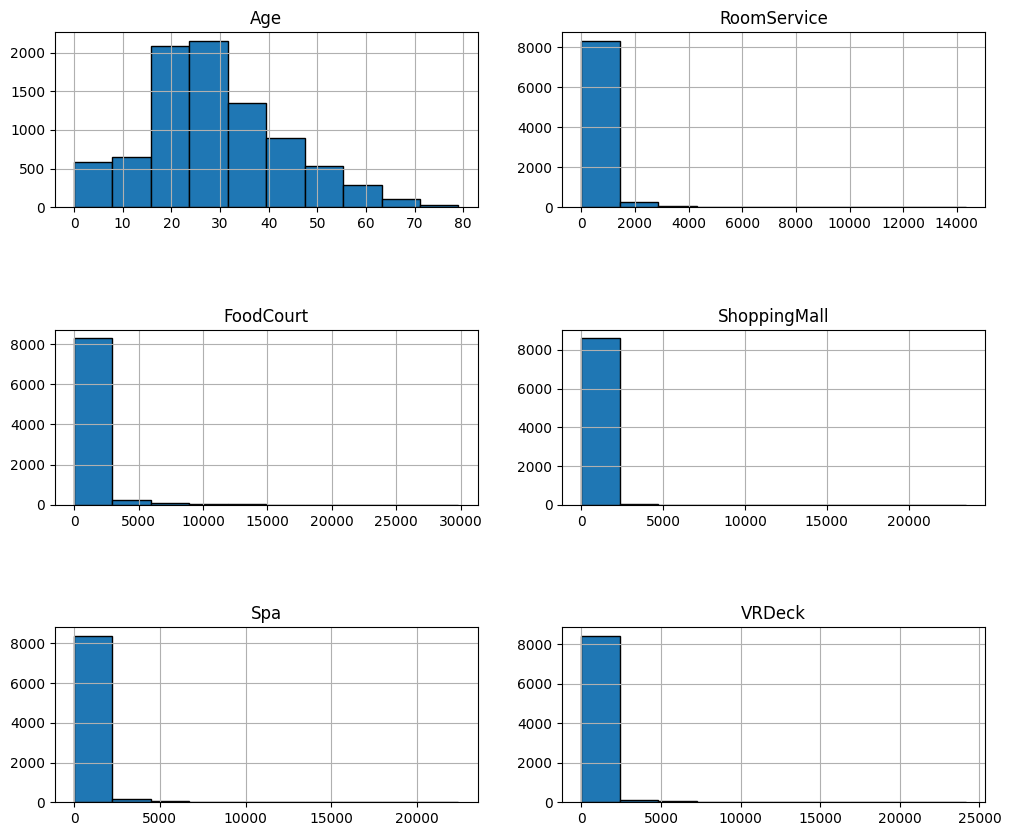

In [ ]:
#Plotting histogram for Continuous features

num_train = df_train[['Age','RoomService','FoodCourt', 'ShoppingMall', 'Spa','VRDeck']]
num_train = (num_train)
num_train.hist(figsize =(12, 10), bins= 10, edgecolor = "black")
plt.subplots_adjust(hspace = 0.7, wspace = 0.2)

Age is approximately normally distributed

other services are mostly not ordered by the passangers with few exceptions

We will need to transform the features

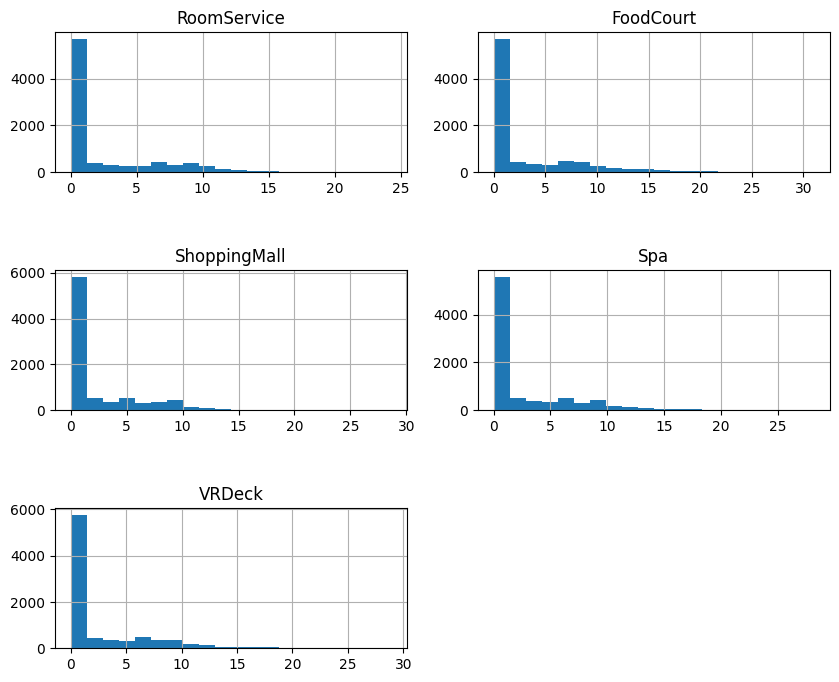

In [ ]:
# log transformation of skewed data

log_data = np.cbrt(df_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])
log_data = (log_data)
log_data.hist(figsize = (10,8), bins = 20)
plt.subplots_adjust(hspace = 0.7, wspace = 0.2)


The transformation had no major change on the distribution of the continous variables. This is because most of the recorded data for these variables is zero.

<Axes: xlabel='HomePlanet'>

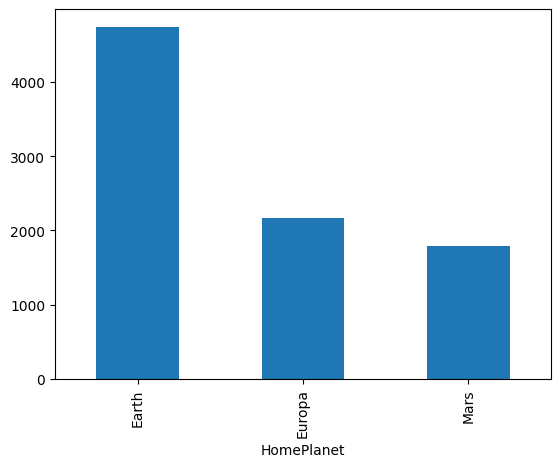

In [ ]:
# Bar Chart for categorical features

df_train['HomePlanet'].value_counts().plot(kind= 'bar')

<Axes: xlabel='CryoSleep'>

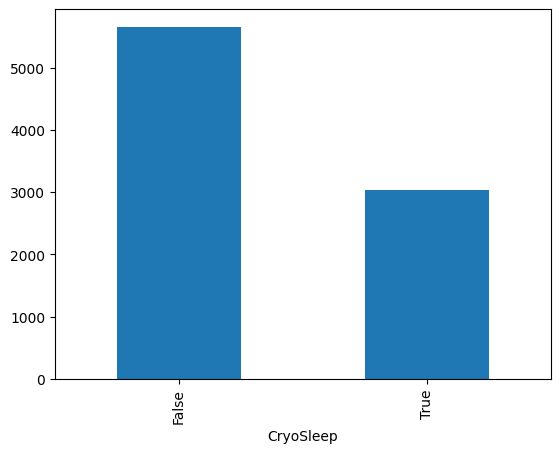

In [ ]:
df_train['CryoSleep'].value_counts().plot(kind= 'bar')

<Axes: xlabel='Destination'>

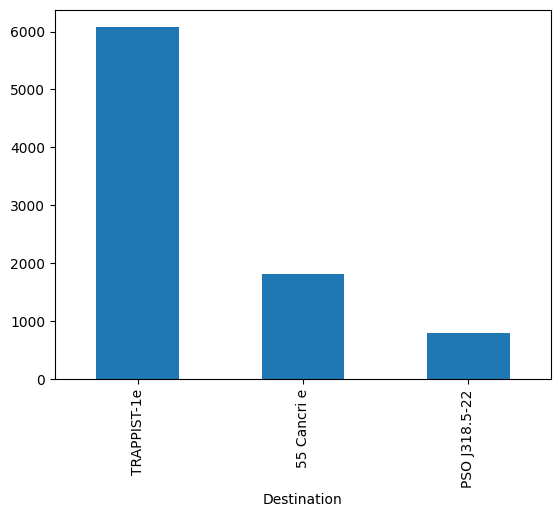

In [ ]:
df_train['Destination'].value_counts().plot(kind = 'bar')

<Axes: xlabel='VIP'>

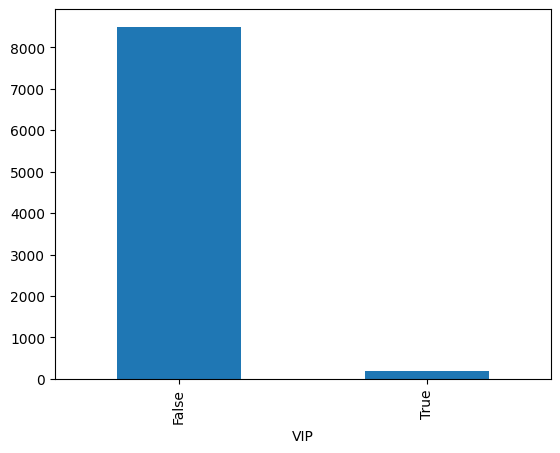

In [ ]:
df_train['VIP'].value_counts().plot(kind = 'bar')

<Axes: xlabel='Transported'>

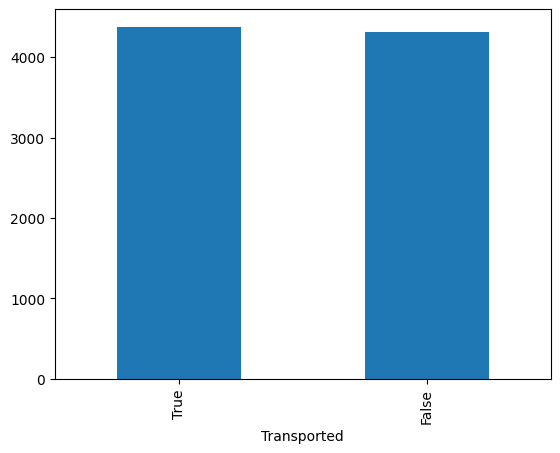

In [ ]:
df_train['Transported'].value_counts().plot(kind = 'bar')

In [ ]:
df_train.Transported.value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

In [ ]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Drop non-numeric columns
numeric_df = df_train.select_dtypes(include=[np.number])

# Add a constant term (intercept) for the VIF calculation
numeric_df = add_constant(numeric_df)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

print(vif_data)

        feature       VIF
0         const  5.137501
1           Age  1.036334
2   RoomService  1.008278
3     FoodCourt  1.104140
4  ShoppingMall  1.004194
5           Spa  1.071354
6        VRDeck  1.069298


#Inferential Analysis

## Exploring Statistical Models

Model Selection:

The dependent variable (outcome) of our dataset is binary.
We will explore 3models; Logistic regression, Decision Tree and Random forest. The model with the highest accuracy score would be use to predict the unseen (test) dataset.

For our model we will use all varaibles except Names and passenger's ID.



### Logistic Regression

In [ ]:
# Covert categorical variables to dummy variables

df_train2 = df_train.copy()
Cat_dummy = pd.get_dummies(df_train2[['HomePlanet', 'Destination', 'Deck']], drop_first=True)

Cat_dummy.head(3)

,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,True,False,False,True,True,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,True,False,False
2,True,False,False,True,False,False,False,False,False,False,False


In [ ]:
# Concatenate the original DataFrame with the DataFrame containing dummy variables
df_train2 = pd.concat([df_train2, Cat_dummy], axis=1)

# Drop the original categorical columns
df_train2.drop(columns=['HomePlanet', 'Destination', 'Deck'], inplace=True)

# Display the updated DataFrame
print(df_train2.head(3))

  PassengerId  CryoSleep  Cabin   Age    VIP  RoomService  FoodCourt  \
0     0001_01      False  B/0/P  39.0  False          0.0        0.0   
1     0002_01      False  F/0/S  24.0  False        109.0        9.0   
2     0003_01      False  A/0/S  58.0   True         43.0     3576.0   

   ShoppingMall     Spa  VRDeck  ... HomePlanet_Mars  \
0           0.0     0.0     0.0  ...           False   
1          25.0   549.0    44.0  ...           False   
2           0.0  6715.0    49.0  ...           False   

   Destination_PSO J318.5-22 Destination_TRAPPIST-1e  Deck_B  Deck_C  Deck_D  \
0                      False                    True    True   False   False   
1                      False                    True   False   False   False   
2                      False                    True   False   False   False   

   Deck_E  Deck_F  Deck_G  Deck_T  
0   False   False   False   False  
1   False    True   False   False  
2   False   False   False   False  

[3 rows x 24 columns

In [ ]:
#Import the required libraries for the analysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [ ]:
# Extracting the independent and dependent variables
X = df_train2[['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep', 'VIP', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F','Deck_G', 'Deck_T']]
y = df_train2['Transported']





In [ ]:
# Standardizing the continous variables

numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
scaler = StandardScaler().fit(df_train2[numerical_features])
scaled_features = scaler.transform(df_train2[numerical_features])

In [ ]:
# Splitting the train dataset 80:20

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [ ]:
# Logistic Regression Model

model = LogisticRegression(penalty = None, max_iter=1000)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7866589994249569


This model prediction is approximately 79% accurate

### Decision Tree Model

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# DecisionTree Model
model1 = DecisionTreeClassifier(random_state = 0)
model1 = model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7354801610120759


The decision gave an accuracy score of approximately 74%

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
#Collection of decision tress
model2 = RandomForestClassifier(n_estimators=1000, max_features=None)

In [ ]:
# Fitting the RandomForest model

model2 = model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
# Checking which of the independent variables are most importance in determining the chances of a passenger being transportes as a result of the collision
importances = model2.feature_importances_

In [ ]:
feature_names = list(X_train.columns.values)
forest_importances = pd.Series(importances, index=feature_names)


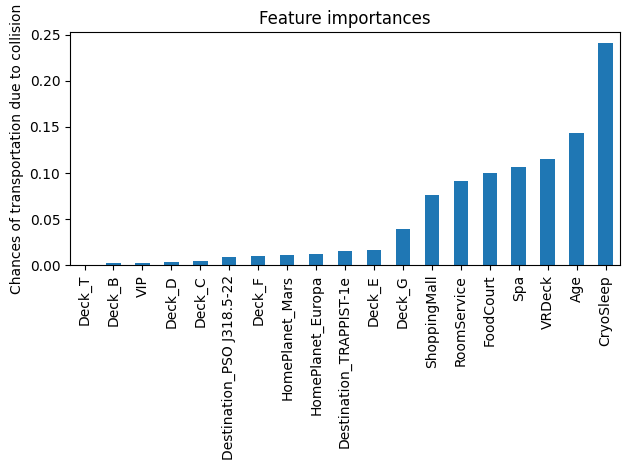

In [ ]:
# Sort feature importances in ascending order
forest_importances_sorted = pd.Series(forest_importances, index=X_train.columns.values).sort_values()
# Plot feature importances
fig, ax = plt.subplots()
forest_importances_sorted.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Chances of transportation due to collision")
fig.tight_layout()
plt.show()

## Predicting the Unseen dataset

In [ ]:
# Covert categorical variables to dummy variables


Cat_dummy_pred = pd.get_dummies(df_predict[['HomePlanet', 'Destination', 'Deck']], drop_first=True)

# Concatenate the original DataFrame with the DataFrame containing dummy variables
df_predict = pd.concat([df_predict, Cat_dummy_pred], axis=1)

# Drop the original categorical columns
df_predict.drop(columns=['HomePlanet', 'Destination', 'Deck'], inplace=True)

# Display the updated DataFrame
print(df_predict.head())

  PassengerId  CryoSleep  Cabin   Age    VIP  RoomService  FoodCourt  \
0     0013_01       True  G/3/S  27.0  False          0.0        0.0   
1     0018_01      False  F/4/S  19.0  False          0.0        9.0   
2     0019_01       True  C/0/S  31.0  False          0.0        0.0   
3     0021_01      False  C/1/S  38.0  False          0.0     6652.0   
4     0023_01      False  F/5/S  20.0  False         10.0        0.0   

   ShoppingMall     Spa  VRDeck  ... HomePlanet_Mars  \
0           0.0     0.0     0.0  ...           False   
1           0.0  2823.0     0.0  ...           False   
2           0.0     0.0     0.0  ...           False   
3           0.0   181.0   585.0  ...           False   
4         635.0     0.0     0.0  ...           False   

  Destination_PSO J318.5-22  Destination_TRAPPIST-1e  Deck_B  Deck_C  Deck_D  \
0                     False                     True   False   False   False   
1                     False                     True   False   False  

In [ ]:
#Predicting the outcome of the unseen data using the Logistic model of the trained data set.

X_predict = df_predict[['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep', 'VIP', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F','Deck_G', 'Deck_T']]
y_transport = model.predict(X_predict)
y_transport_list = y_transport.tolist()


In [ ]:
# Converting the prediction into a list, to allow us include it in the CSV file
df_predict['predicted_transport'] = y_transport_list
df_predict.to_csv('predicted_transport_data.csv', index=False)

In [ ]:
from google.colab import files
files.download('predicted_transport_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 1: Check y_transport
print(y_transport)

[ True False  True ...  True  True  True]


In [ ]:
# Assuming you want to count the unique values in the 'Deck' column
unique_counts = df_predict['predicted_transport'].value_counts()
# Print the unique counts
print(unique_counts)

predicted_transport
True     2256
False    2021
Name: count, dtype: int64


The prediction shows that out of 4277 passengers  in the test dataset, 2256 were transported as a result of the collision.